<a href="https://colab.research.google.com/github/hsnbnaa/deep-learning-is-easy/blob/main/Hands-on%20Machine%20Learning%20with%20Scikit-Learn%2C%20Keras%20%26%20TensorFlow/Chapter%2018/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym

# Membuat lingkungan
env = gym.make("CartPole-v1", render_mode="human")  # Gunakan render_mode="human" untuk melihat visualisasi

# Reset ke state awal
obs, info = env.reset()
done = False
truncated = False
total_reward = 0

while not (done or truncated):
    # Pilih aksi (di sini aksi acak, bisa diganti dengan strategi atau model RL)
    action = env.action_space.sample()  # Aksi random (0 = kiri, 1 = kanan)

    # Ambil langkah di lingkungan
    obs, reward, done, truncated, info = env.step(action)

    total_reward += reward

# Tutup lingkungan setelah selesai
env.close()

print("Total reward:", total_reward)


Total reward: 11.0


In [2]:
import tensorflow as tf
from tensorflow import keras

# Contoh arsitektur Policy Network sederhana
n_inputs = 4 # Untuk CartPole (posisi, kecepatan, sudut, kecepatan sudut)
n_outputs = 2 # Untuk CartPole (dorong kiri atau kanan)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs, activation="softmax"), # Output probabilitas untuk setiap aksi
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


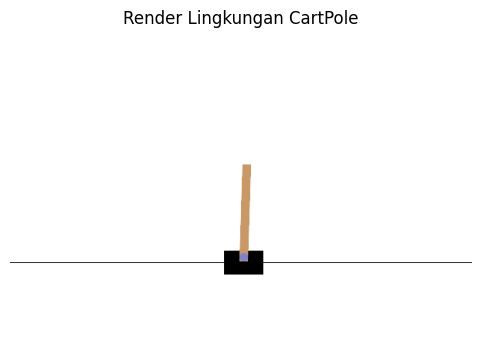

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt

# Membuat lingkungan dan meresetnya
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=42)

# Merender satu frame dari lingkungan
img = env.render()

# Menampilkan frame menggunakan matplotlib
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis("off")
plt.title("Render Lingkungan CartPole")
plt.show()

env.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# --- 1. Helper functions ---

def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        obs_input = tf.expand_dims(obs, axis=0)
        logits = model(obs_input)
        action = tf.random.categorical(logits, num_samples=1)[0, 0]
        y_true = tf.one_hot([action], depth=env.action_space.n)
        loss = tf.reduce_mean(loss_fn(y_true, logits))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        obs, _ = env.reset()
        episode_rewards = []
        episode_grads = []
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(env, obs, model, loss_fn)
            episode_rewards.append(reward)
            episode_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(episode_rewards)
        all_grads.append(episode_grads)
    return all_rewards, all_grads

def discount_rewards(rewards, discount_factor=0.95):
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0
    for step in reversed(range(len(rewards))):
        cumulative = rewards[step] + cumulative * discount_factor
        discounted[step] = cumulative
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor=0.95):
    all_discounted = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted)
    mean = np.mean(flat_rewards)
    std = np.std(flat_rewards)
    return [(rewards - mean) / (std + 1e-8) for rewards in all_discounted]

In [5]:
# --- 2. Policy model, loss, optimizer ---

env = gym.make("CartPole-v1")
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(n_outputs)
])

loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.01)


In [9]:
# --- 3. Training loop ---

n_iterations = 10
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95
all_mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    # Terapkan rata-rata gradien berbobot reward
    mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads.append(
            tf.reduce_mean([
                final_reward[step] * all_grads[episode][step][var_index]
                for episode, final_reward in enumerate(all_final_rewards)
                for step in range(len(final_reward))
            ], axis=0)
        )

    optimizer.apply_gradients(zip(mean_grads, model.trainable_variables))

    # Logging
    total_rewards = [sum(rewards) for rewards in all_rewards]
    mean_reward = np.mean(total_rewards)
    all_mean_rewards.append(mean_reward)
    print(f"Iteration {iteration + 1}: mean reward = {mean_reward:.2f}")

env.close()

Iteration 1: mean reward = 25.00
Iteration 2: mean reward = 37.50
Iteration 3: mean reward = 31.60
Iteration 4: mean reward = 33.30
Iteration 5: mean reward = 40.50
Iteration 6: mean reward = 55.00
Iteration 7: mean reward = 65.00
Iteration 8: mean reward = 51.70
Iteration 9: mean reward = 85.00
Iteration 10: mean reward = 87.40


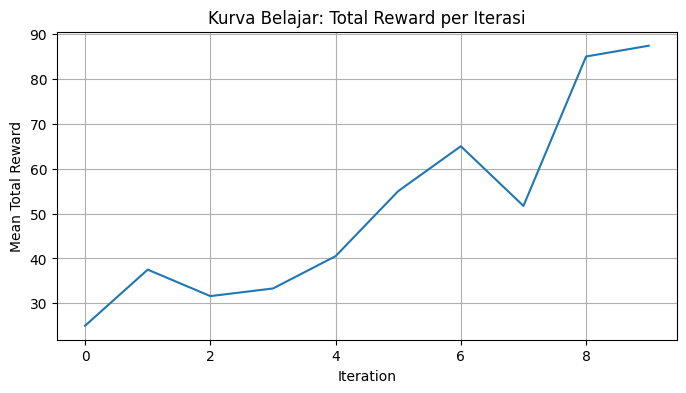

In [10]:
# --- 4. Plotting ---

plt.figure(figsize=(8, 4))
plt.plot(all_mean_rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean Total Reward")
plt.title("Kurva Belajar: Total Reward per Iterasi")
plt.grid(True)
plt.show()